# Seol Bike Sharing Demand Prediction

## Contents
1. Data Description
2. Gather The Data
3. Read and Process The Data
4. Perform Exploratory Analysis
5. Feature Engineering
6. Conclusion and Next Steps

## 1. Data Description

- Date : year-month-day
- Rented Bike count - Count of bikes rented at each hour
- Hour - Hour of he day
- Temperature-Temperature in Celsius
- Humidity - %
- Windspeed - m/s
- Visibility - 10m
- Dew point temperature - Celsius 
- Solar radiation - MJ/m2
- Rainfall - mm
- Snowfall - cm
- Seasons - Winter, Spring, Summer, Autumn
- Holiday - Holiday/No holiday
- Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

## 2. Gather the Data

> Importing the libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import warnings
import requests
import zipfile
warnings.filterwarnings('ignore')

In [4]:
# Download the data and extract it into the input/raw folder

url = 'https://archive.ics.uci.edu/static/public/560/seoul+bike+sharing+demand.zip'
file_name = 'seoul_bike_sharing_demand.zip'

# Stream the download
with requests.get(url, stream=True) as r:
    with open(file_name, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

# Unzip the data and place it in the input raw folder
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall('../input/raw/')
os.remove(file_name)

## 3. Read and Process The Data

In [5]:
df_bike = pd.read_csv('../input/raw/SeoulBikeData.csv', encoding='latin1')
df_bike.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [6]:
# Create a function to process the dataframe columns names
# - Relace spaces with underscores
# - Remove parentheses with their content
# - Convert to lowercase
def process_col_names(df):
    df.columns = df.columns.str.replace(r"\(.*\)","", regex=True).str.strip()
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.str.lower()
    return df

In [7]:
df_bike = process_col_names(df_bike)
df_bike.head()

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [8]:
df_bike.shape

(8760, 14)

* We have 8760 observations and 14 features in our dataset.

In [9]:
# Let's check for any missing values in the dataset
df_bike.isnull().sum()

date                     0
rented_bike_count        0
hour                     0
temperature              0
humidity                 0
wind_speed               0
visibility               0
dew_point_temperature    0
solar_radiation          0
rainfall                 0
snowfall                 0
seasons                  0
holiday                  0
functioning_day          0
dtype: int64

> - Good News: There is no missing value in the dataset.

In [10]:
# Let see what the data types are
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   8760 non-null   object 
 1   rented_bike_count      8760 non-null   int64  
 2   hour                   8760 non-null   int64  
 3   temperature            8760 non-null   float64
 4   humidity               8760 non-null   int64  
 5   wind_speed             8760 non-null   float64
 6   visibility             8760 non-null   int64  
 7   dew_point_temperature  8760 non-null   float64
 8   solar_radiation        8760 non-null   float64
 9   rainfall               8760 non-null   float64
 10  snowfall               8760 non-null   float64
 11  seasons                8760 non-null   object 
 12  holiday                8760 non-null   object 
 13  functioning_day        8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ 

In [11]:
# Let's wtite a function to convert date columns to datetime and all other object columns to category
def convert_dtypes(df):
    for col in df.columns:
        if 'date' in col:
            df[col] = pd.to_datetime(df[col], format='%d/%m/%Y')
        # We will include 'hour' int category as well, since it will have discrete values
        elif 'hour' in col:
            df[col] = df[col].astype('category')
        elif df[col].dtype == 'object':
            df[col] = df[col].astype('category')
        else:
            pass
    return df

In [12]:
df_bike = convert_dtypes(df_bike)
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   8760 non-null   datetime64[ns]
 1   rented_bike_count      8760 non-null   int64         
 2   hour                   8760 non-null   category      
 3   temperature            8760 non-null   float64       
 4   humidity               8760 non-null   int64         
 5   wind_speed             8760 non-null   float64       
 6   visibility             8760 non-null   int64         
 7   dew_point_temperature  8760 non-null   float64       
 8   solar_radiation        8760 non-null   float64       
 9   rainfall               8760 non-null   float64       
 10  snowfall               8760 non-null   float64       
 11  seasons                8760 non-null   category      
 12  holiday                8760 non-null   category      
 13  fun

In [13]:
# Let's see the numeric data statistics
df_bike.describe(include=['int', 'float']).T.style.bar(
        subset=['mean'], color='#205ff2'
    ).background_gradient(
        subset=['std'], cmap='Reds'
    ).background_gradient(
        subset=['50%'], cmap='coolwarm'
    )

,count,mean,std,min,25%,50%,75%,max
rented_bike_count,8760.000000,704.602055,644.997468,0.000000,191.000000,504.500000,1065.250000,3556.000000
temperature,8760.000000,12.882922,11.944825,-17.800000,3.500000,13.700000,22.500000,39.400000
humidity,8760.000000,58.226256,20.362413,0.000000,42.000000,57.000000,74.000000,98.000000
wind_speed,8760.000000,1.724909,1.036300,0.000000,0.900000,1.500000,2.300000,7.400000
visibility,8760.000000,1436.825799,608.298712,27.000000,940.000000,1698.000000,2000.000000,2000.000000
dew_point_temperature,8760.000000,4.073813,13.060369,-30.600000,-4.700000,5.100000,14.800000,27.200000
solar_radiation,8760.000000,0.569111,0.868746,0.000000,0.000000,0.010000,0.930000,3.520000
rainfall,8760.000000,0.148687,1.128193,0.000000,0.000000,0.000000,0.000000,35.000000
snowfall,8760.000000,0.075068,0.436746,0.000000,0.000000,0.000000,0.000000,8.800000


> - For variables **rented_bike_count** and **visibility** the std is very high, they may contain outliers.

In [14]:
# Let's see the categorical data statistics
df_bike.describe(include=['category']).T

,count,unique,top,freq
hour,8760,24,0,365
seasons,8760,4,Spring,2208
holiday,8760,2,No Holiday,8328
functioning_day,8760,2,Yes,8465


In [15]:
# Let's see the statistical summary of the date column
print("Min Date: ", df_bike['date'].min())
print("Max Date: ", df_bike['date'].max())
print("Range: ", df_bike['date'].max() - df_bike['date'].min())

Min Date:  2017-12-01 00:00:00
Max Date:  2018-11-30 00:00:00
Range:  364 days 00:00:00


## 4. Perform Exploratory Analysis

* Numeric Features

In [16]:
# Let's see all numeric columns
numeric_cols = df_bike.select_dtypes(include=np.number).columns
numeric_cols

Index(['rented_bike_count', 'temperature', 'humidity', 'wind_speed',
       'visibility', 'dew_point_temperature', 'solar_radiation', 'rainfall',
       'snowfall'],
      dtype='object')

In [17]:
def create_subplots(df, columns):
    num_rows = (len(columns) + 2) // 3
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 3 * num_rows))

    for i, column in enumerate(columns):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        sns.histplot(df[column], kde=True, ax=ax)  # Replace with your Seaborn plot function

        ax.set_title(f'{column} Distribution')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


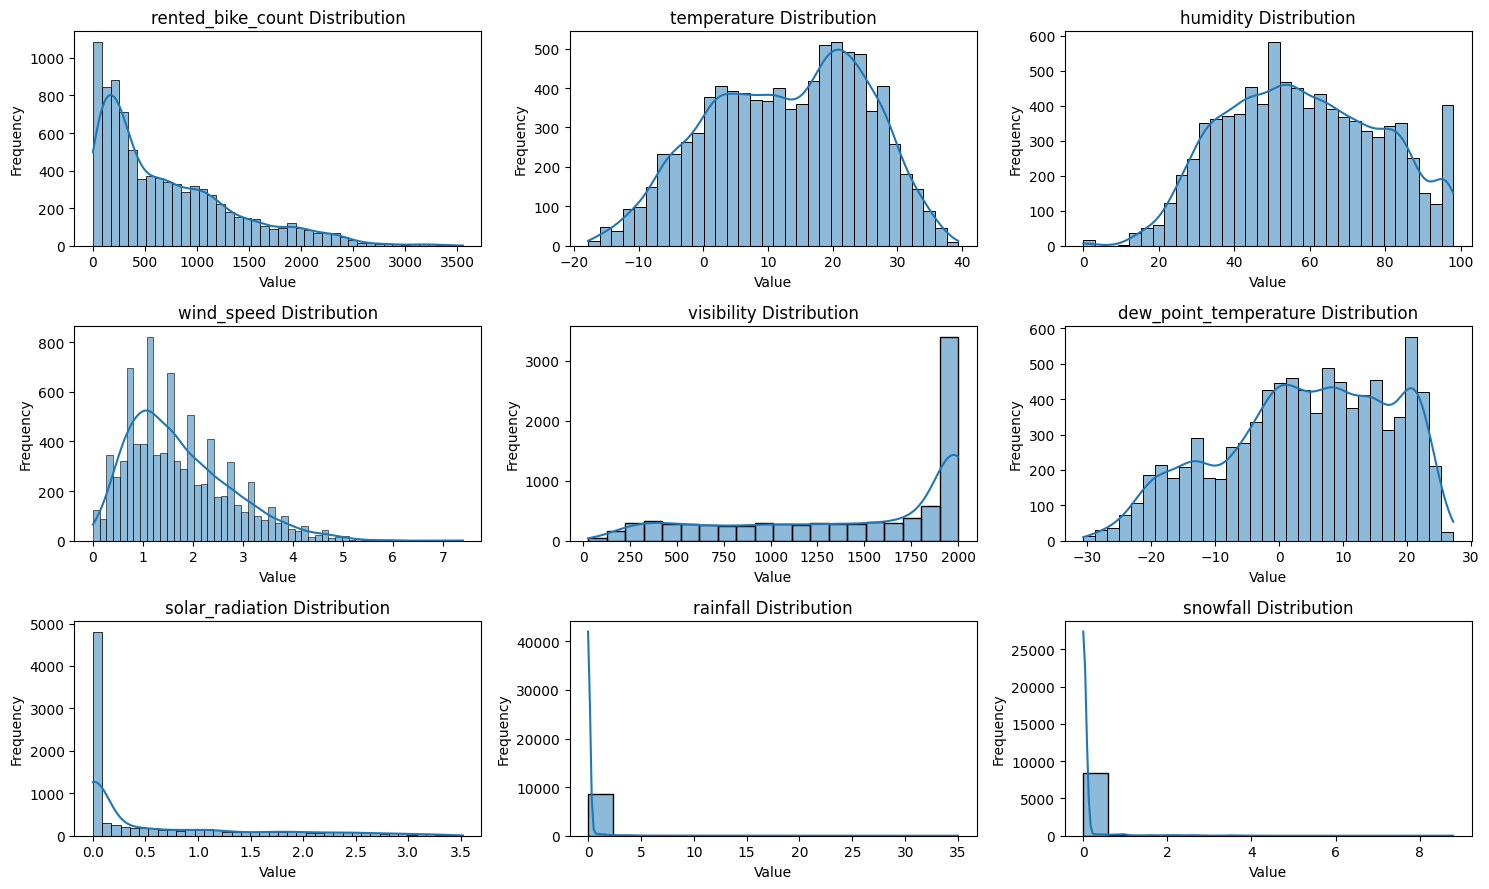

In [18]:
create_subplots(df_bike, numeric_cols)

> - rented_bike_count, wind_speed, solar_radiation, rainfall and snowfall are right skewed. 
>
> - visibility is left skewed.

In [19]:
# Let's see all categorical columns
cat_cols = df_bike.select_dtypes(include='category').columns
cat_cols

Index(['hour', 'seasons', 'holiday', 'functioning_day'], dtype='object')

In [20]:
# Let's create a function to plot the categorical columns
def create_cat_subplots(df, columns):
    num_rows = (len(columns) + 2) // 3
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 3 * num_rows))

    for i, column in enumerate(columns):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        sns.countplot(df[column], ax=ax)  # Replace with your Seaborn plot function

        ax.set_title(f'{column} Distribution')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

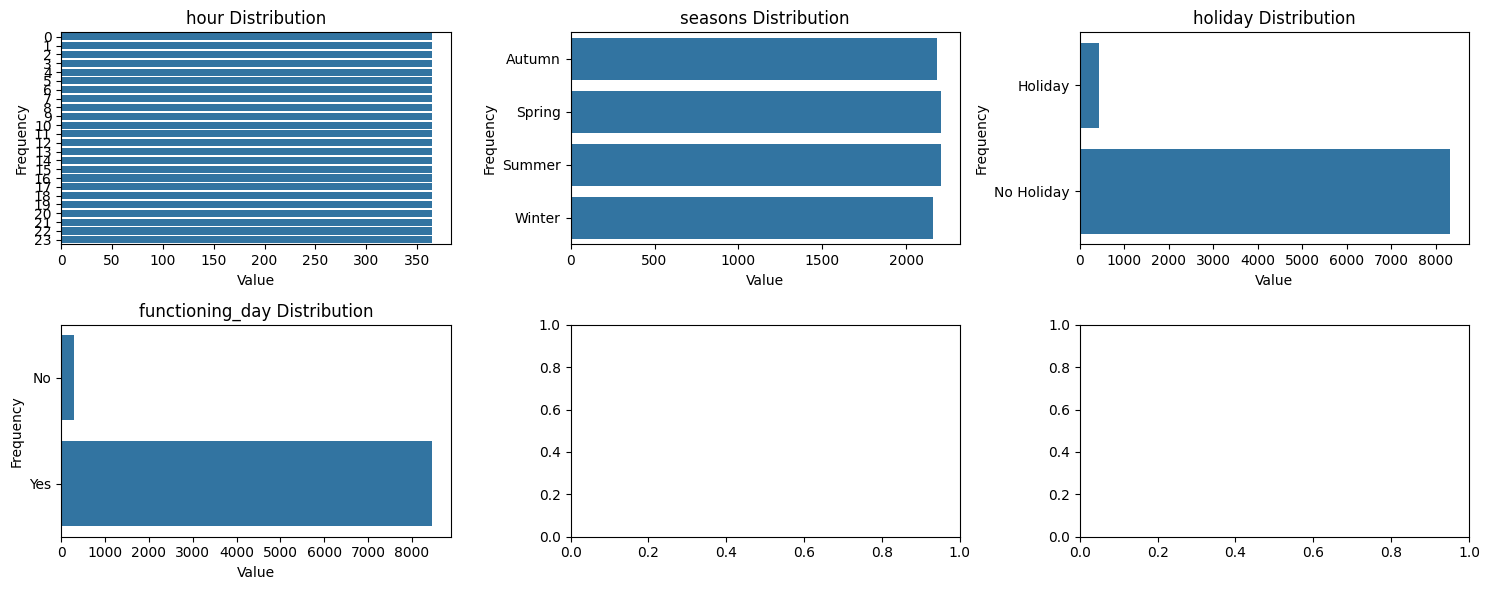

In [21]:
create_cat_subplots(df_bike, cat_cols)

> - Distribution of hour and seasons are uniform.
>
> - Holidays are very less in number. which is expected.
>
> - Functional days very high in number. which is expected.

In [22]:
# Let's see how the target variable is affected by the numeric columns
def create_numeric_target_sub(df, columns, target):
    num_rows = (len(columns) + 2) // 3
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 3 * num_rows))

    for i, column in enumerate(columns):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        sns.scatterplot(x=df[column].values, y=df[target].values, ax=ax)  # Replace with your Seaborn plot function

        ax.set_title(f'{column} vs {target}')
        ax.set_xlabel(column)
        ax.set_ylabel(target)

    plt.tight_layout()
    plt.show()

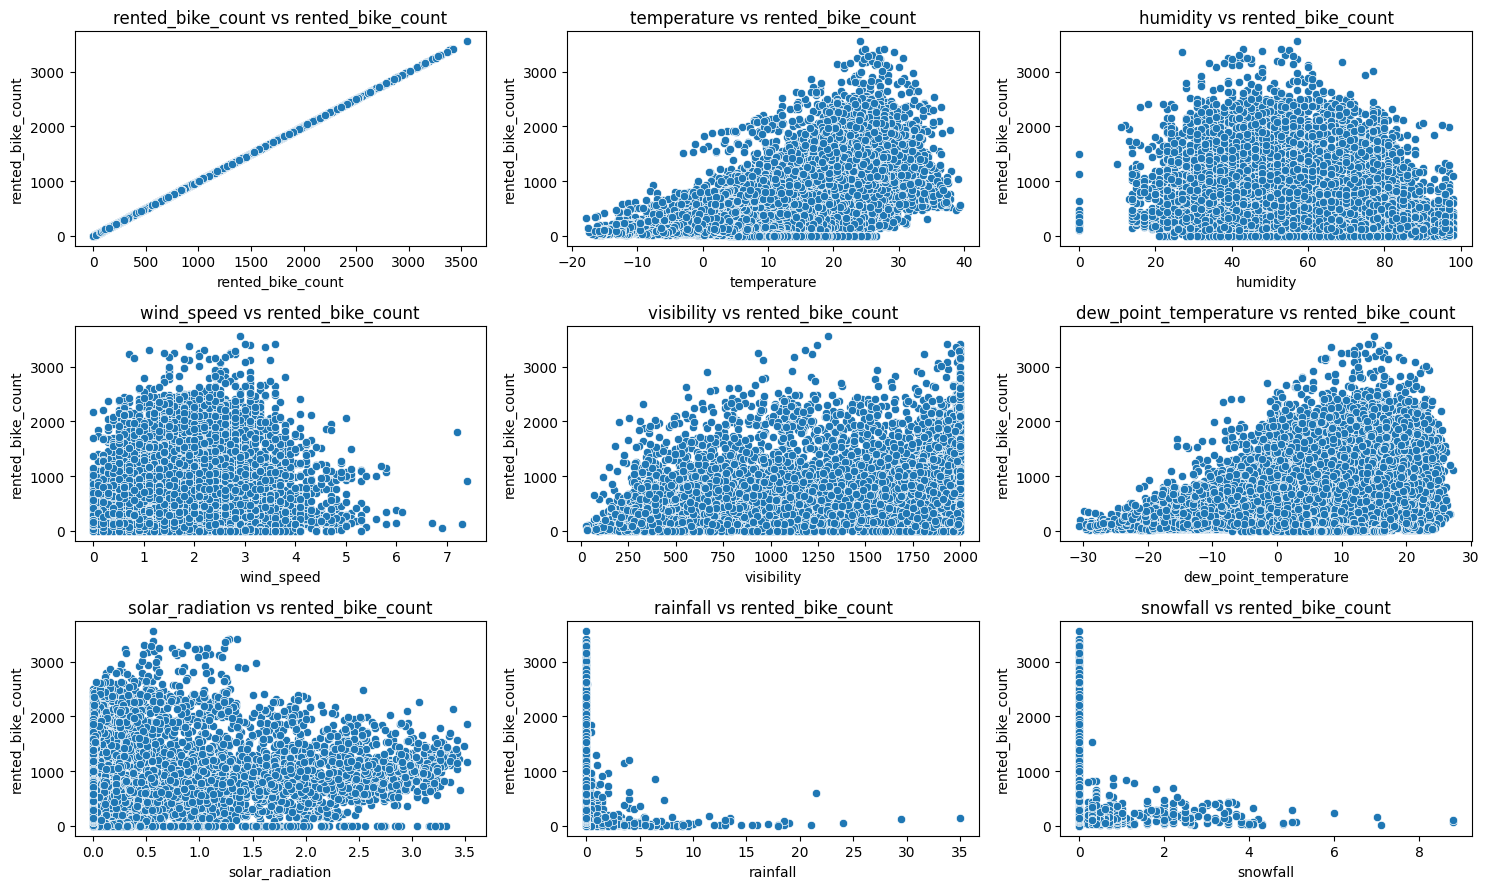

In [23]:
create_numeric_target_sub(df_bike, numeric_cols, 'rented_bike_count')

> - most bikes are rented when the rainfall and snowfall is close to zero. which is expected.
>
> - temperature and dew point temperature re positively correlated with bikes rented.
>
> - We will explore futher with correlation matrix.

In [24]:
# Let's create a function to plot the categorical columns against the target variable
def create_cat_target_sub(df, columns, target):
    num_rows = (len(columns) + 2) // 3
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 3 * num_rows))

    for i, column in enumerate(columns):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        sns.boxplot(x=df[column].values, y=df[target].values, ax=ax)  # Replace with your Seaborn plot function

        ax.set_title(f'{column} vs {target}')
        ax.set_xlabel(column)
        ax.set_ylabel(target)

    plt.tight_layout()
    plt.show()

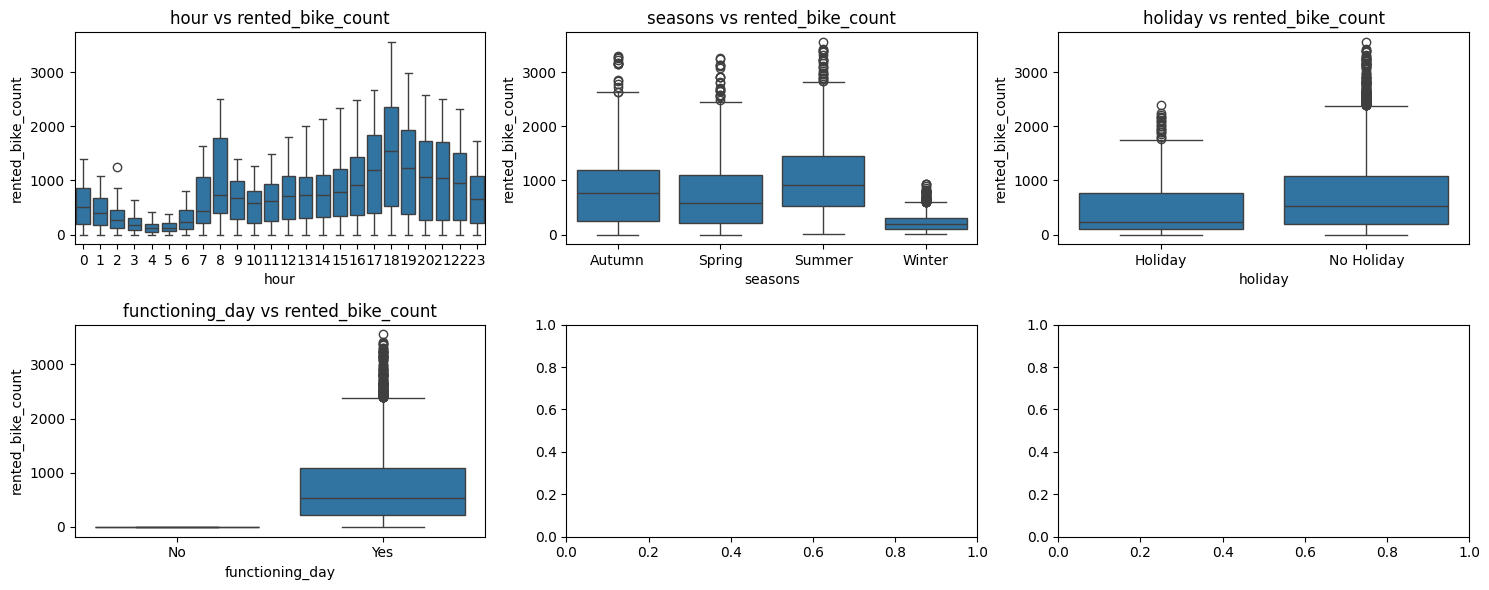

In [25]:
create_cat_target_sub(df_bike, cat_cols, 'rented_bike_count')

> - We can see the peak hours of bike renting between ~7-9 and ~17-21. It may be because of office hours.
>
> - bike renting is at lowest between in winter season.
>
> - No Holiday contributes to more bike renting. It may be because of working days.
>
> - bike renting is 0 in non functional days.

## 5. Feature Engineering

In [66]:
# We can create more time related feature from date and see how different time features affect the count of rented bikes
# Let's create a function to create time features
def create_time_features(df):
    df["day"] = df.date.dt.day
    df["month"] = df.date.dt.month
    df["year"] = df.date.dt.year
    df["day_of_week"] = df.date.dt.dayofweek
    df["day_of_year"] = df.date.dt.dayofyear
    df["week_of_year"] = df.date.dt.isocalendar().week.astype(int)
    df["date_index"] = df.date.factorize()[0]
    return df

In [67]:
df_bike = create_time_features(df_bike)

In [68]:
df_bike.head()

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,...,holiday,functioning_day,year,month,day,dayofweek,day_of_week,day_of_year,week_of_year,date_index
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,...,No Holiday,Yes,2017,12,1,4,4,335,48,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,...,No Holiday,Yes,2017,12,1,4,4,335,48,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,...,No Holiday,Yes,2017,12,1,4,4,335,48,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,...,No Holiday,Yes,2017,12,1,4,4,335,48,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,...,No Holiday,Yes,2017,12,1,4,4,335,48,0


In [55]:
# Let's Crate a function to plot the time features against the target variable
COLORS = sns.color_palette()
def create_time_target_sub(df, target):
    plot_properties = {
        'linewidth': 2,
        'flierprops': {"alpha": 0.2},
        'orient': 'h',
    }

    fig = plt.figure(figsize=(18, 24))
    gs = fig.add_gridspec(5, 2, height_ratios=[3, 5, 2, 5, 5])

    sns.boxplot(
        x=df[target].values, 
        y=df['day_of_week'].values,
        color=COLORS[0], 
        ax=fig.add_subplot(gs[0, 0]), 
        **plot_properties
    )
    plt.title('Bike Rentals by Day of Week')

    sns.boxplot(
        x=df[target].values, 
        y=df['month'].values, 
        color=COLORS[1],
        ax=fig.add_subplot(gs[1, 0]), 
        **plot_properties
    )
    plt.title('Bike Rentals by Month')
    
    sns.boxplot(
        x=df[target].values, 
        y=df['year'].values, 
        color=COLORS[2],
        ax=fig.add_subplot(gs[2, 0]), 
        **plot_properties
    )
    plt.title('Bike Rentals by Year')

    sns.boxplot(
        x=df[target].values, 
        y=df['day'].values, 
        color=COLORS[3],
        ax=fig.add_subplot(gs[:3, 1]), 
        **plot_properties
    )
    plt.title('Bike Rentals by Day of Month')

    sns.lineplot(
        y=df[target].values, 
        x=df['day_of_year'].values, 
        color=COLORS[4],
        ax=fig.add_subplot(gs[3, 0]), 
        linewidth=2,
    )
    plt.title('Bike Rentals by Day of Year')
    plt.xlabel('Day of Year')
    plt.ylabel('Bike Rentals')

    sns.lineplot(
        y=df[target].values, 
        x=df['week_of_year'].values, 
        color=COLORS[4],
        ax=fig.add_subplot(gs[3, 1]), 
        linewidth=2,
    )
    plt.title('Bike Rentals by Week of Year')
    plt.xlabel('Week of Year')
    plt.ylabel('Bike Rentals')

    sns.lineplot(
        y=df[target].values,
        x=df['date_index'].values,  
        color=COLORS[4],
        ax=fig.add_subplot(gs[4, :]), 
        linewidth=2,
    )
    plt.title('Bike Rentals by Date Index')
    plt.xlabel('Date Index')
    plt.ylabel('Bike Rentals')

    plt.tight_layout()
    plt.show()

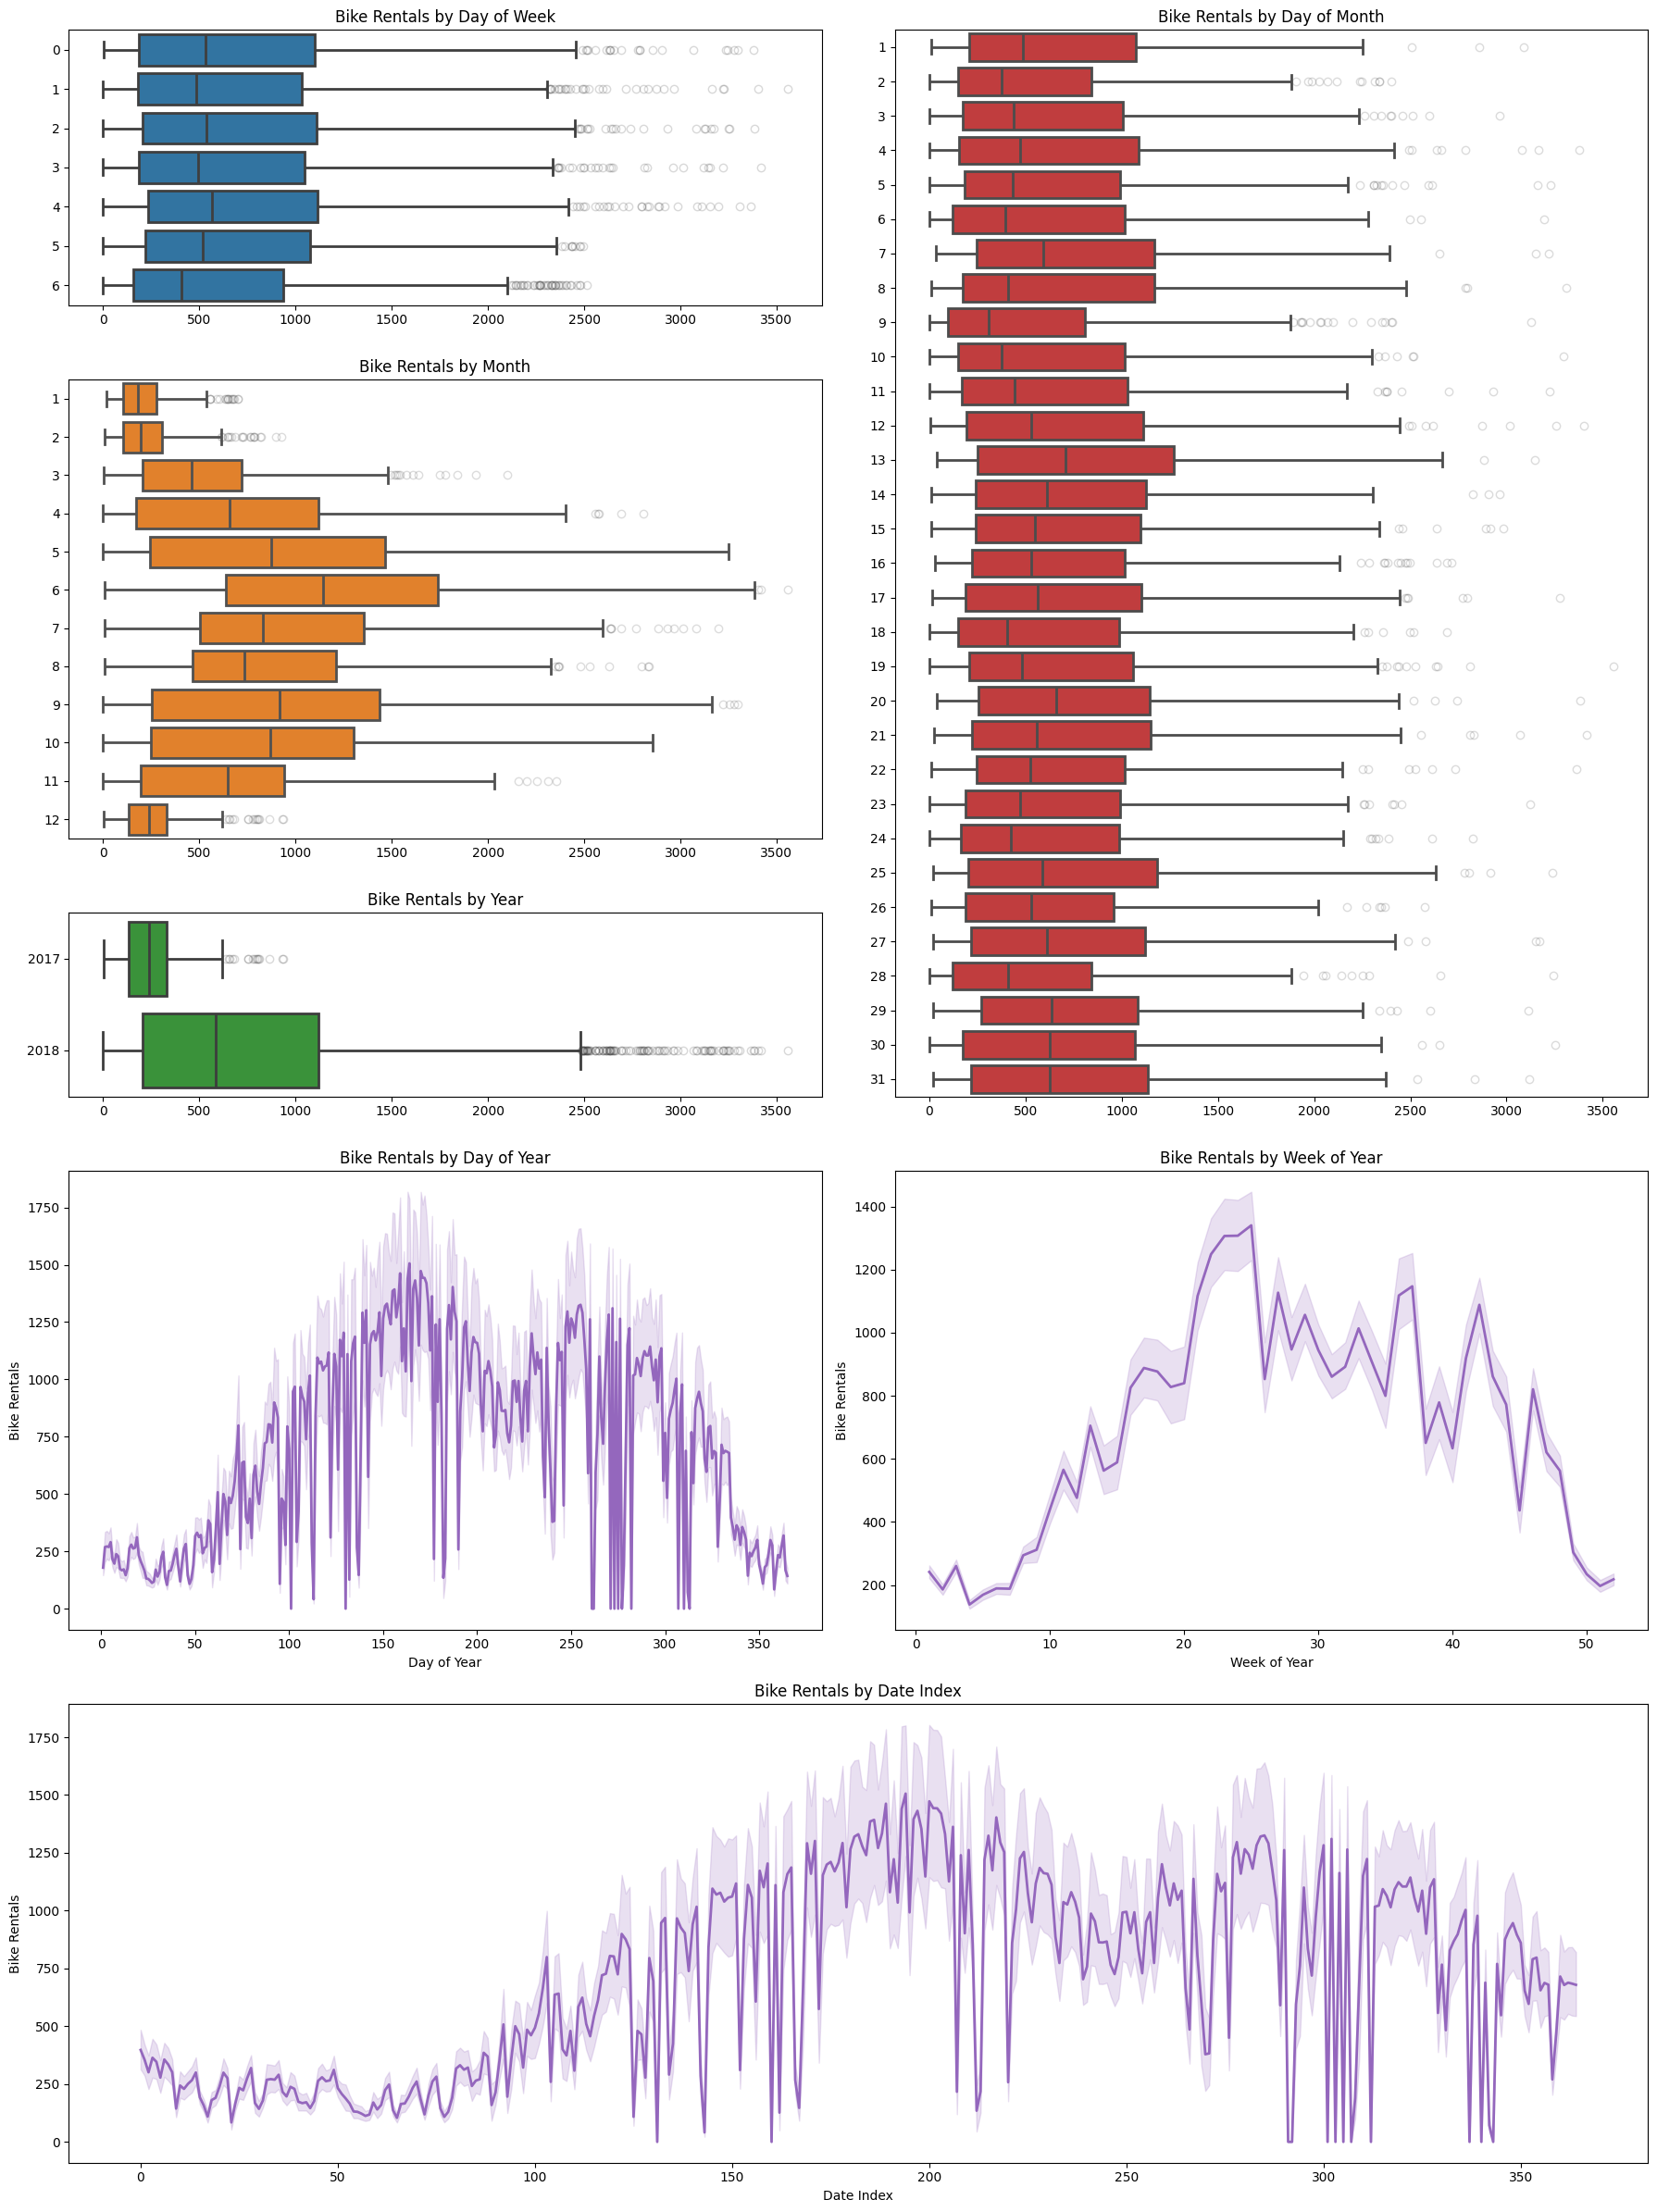

In [56]:
create_time_target_sub(df_bike, 'rented_bike_count')

> - bike renting is at lowest on sundays.
>
> - bike renting is at highest in summer season.
>
> - bike renting is at highest on working days.
>
> - We can see increasing trend in bike renting then a dip, it may be because of winter season at the end of the year.
>
> - Day and Week of the year clearly shows the increasing trend in bike renting in summer season.
>
> - bike renting is at very high in year 2018 because we only have December month data for year 2017.

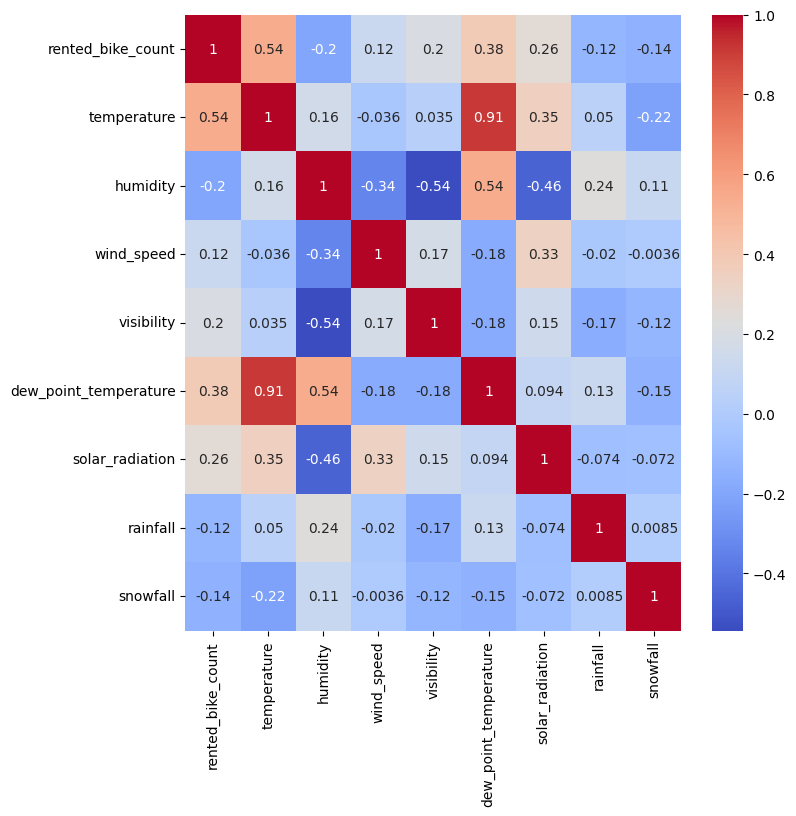

In [74]:
# Let's create a heatmap to see the correlation between the numeric columns
plt.figure(figsize=(8, 8))
sns.heatmap(df_bike[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.show()

> - temperature and dew point temperature are highly correlated. We will consider dropping one of them in case of regression algorithms.

## 6. Conclusion and Next Steps

In [77]:
df_bike.to_pickle('../input/processed/df_bike.pkl')